# 1.Dataset
## Overview
Fraud risk is everywhere, but for companies that advertise online, click fraud can happen at an overwhelming volume, resulting in misleading click data and wasted money. Ad channels can drive up costs by simply clicking on the ad at a large scale. With over 1 billion smart mobile devices in active use every month, China is the largest mobile market in the world and therefore suffers from huge volumes of fradulent traffic.

##Data Fields

* ip: ip address of click.
* app: app id for marketing.
* device: device type id of user mobile phone (e.g., iphone 6 plus, iphone 7, huawei mate 7, etc.)
* os: os version id of user mobile phone
* channel: channel id of mobile ad publisher
* click_time: timestamp of click (UTC)
* attributed_time: if user download the app for after clicking an ad, this is the time of the app * download
* is_attributed: the target that is to be predicted, indicating the app was downloaded
* Note that ip, app, device, os, and channel are encoded.

The test data is similar, with the following differences:

* click_id: reference for making predictions
* is_attributed: not included

1. Data Collection

In [1]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!ls "/content/drive/My Drive/click/data"

 click_id.csv		 sub_lgb.csv	       train.csv
'Copy of sub_lgb.csv'	 test.csv	       train_sample.csv
 sample_submission.csv	 test_supplement.csv   Untitled0.ipynb


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import missingno as msno

%matplotlib inline

### Load the dataset

In [0]:
dtypes = {
        'ip'            : 'uint16',
        'app'           : 'uint16',
        'device'        : 'uint16',
        'os'            : 'uint16',
        'channel'       : 'uint16',
        'is_attributed' : 'uint8',
        'click_id'      : 'uint32' # note that click_id is only in test data, not training data
        }

In [0]:
train = pd.read_csv('/content/drive/My Drive/click/data/train_sample.csv',  parse_dates=['click_time'], dtype=dtypes)
test = pd.read_csv('/content/drive/My Drive/click/data/test.csv', parse_dates=['click_time'], dtype=dtypes)

# 2. Data Summary


*   Size of the dataset
*   Get a glimpse of data by printing few rows of it
*   Contributed Type of variables 





In [6]:
# Shae of the dataset
print(train.shape, test.shape)

(100000, 8) (18790469, 7)


In [7]:
# Check the data
train.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,22004,12,1,13,497,2017-11-07 09:30:38,NaN,0
1,40024,25,1,17,259,2017-11-07 13:40:27,NaN,0
2,35888,12,1,19,212,2017-11-07 18:05:24,NaN,0
3,29048,13,1,13,477,2017-11-07 04:58:08,NaN,0
4,2877,12,1,1,178,2017-11-09 09:00:09,NaN,0


In [8]:
test.head()

,click_id,ip,app,device,os,channel,click_time
0,0,5744,9,1,3,107,2017-11-10 04:00:00
1,1,54365,9,1,3,466,2017-11-10 04:00:00
2,2,6751,21,1,19,128,2017-11-10 04:00:00
3,3,12941,15,1,13,111,2017-11-10 04:00:00
4,4,57544,12,1,13,328,2017-11-10 04:00:00


In [9]:
# train.coluumns
# train.dypes
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
ip                 100000 non-null uint16
app                100000 non-null uint16
device             100000 non-null uint16
os                 100000 non-null uint16
channel            100000 non-null uint16
click_time         100000 non-null datetime64[ns]
attributed_time    227 non-null object
is_attributed      100000 non-null uint8
dtypes: datetime64[ns](1), object(1), uint16(5), uint8(1)
memory usage: 2.6+ MB


In [10]:
# Check the missing data
train.isnull().sum()

ip                     0
app                    0
device                 0
os                     0
channel                0
click_time             0
attributed_time    99773
is_attributed          0
dtype: int64

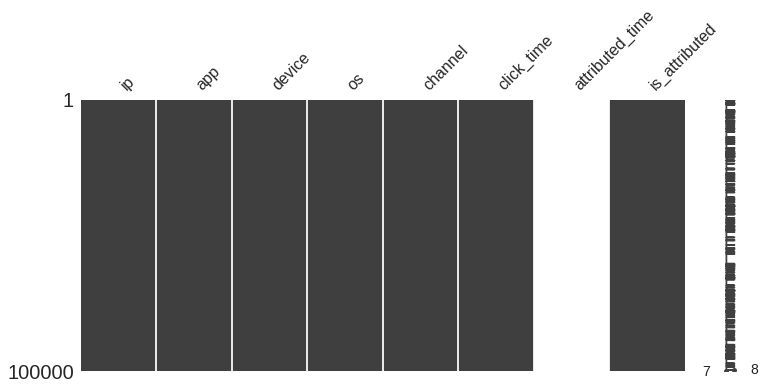

In [11]:
msno.matrix(train, figsize=(12,5))

In [12]:
test.isnull().sum()

click_id      0
ip            0
app           0
device        0
os            0
channel       0
click_time    0
dtype: int64

In [13]:
# Number of unique values in each column
def fraction_unique(x):
    return len(train[x].unique())

uvalues = {x: fraction_unique(x) for x in train.columns}
uvalues

{'app': 161,
 'attributed_time': 228,
 'channel': 161,
 'click_time': 80350,
 'device': 100,
 'ip': 28470,
 'is_attributed': 2,
 'os': 130}

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)
/usr/local/lib/python3.6/dist-packages/matplotlib/scale.py:111: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


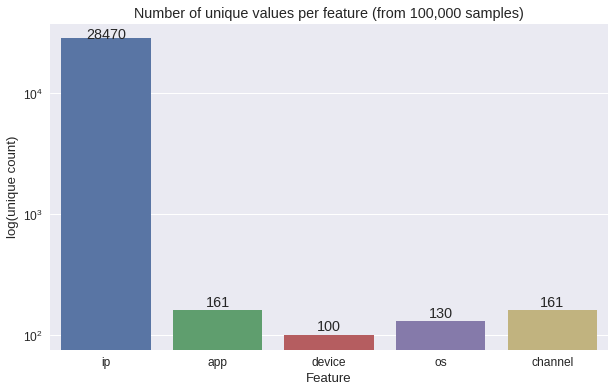

In [14]:
plt.figure(figsize=(10, 6))
cols = ['ip', 'app', 'device', 'os', 'channel']
uniques = [len(train[col].unique()) for col in cols]
sns.set(font_scale=1.2)
ax = sns.barplot(cols, uniques, log=True)
ax.set(xlabel='Feature', ylabel='log(unique count)', title='Number of unique values per feature (from 100,000 samples)');
for p, uniq in zip(ax.patches, uniques):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
        height + 10,
        uniq,
        ha="center") 

IP address has most values with 28470.

Downloaded (%): 
0    99.77
1     0.23
Name: is_attributed, dtype: float64
Downloaded (Number): 
0    99773
1      227
Name: is_attributed, dtype: int64


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


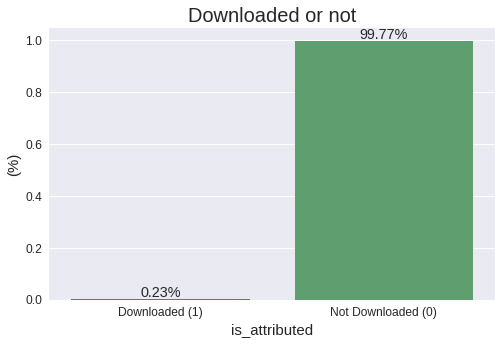

In [15]:
print('Downloaded (%): ')
print(round((train.is_attributed.value_counts() / len(train.is_attributed) * 100),2))

print('Downloaded (Number): ')
print(train.is_attributed.value_counts())

plt.figure(figsize=(8, 5))
sns.set(font_scale=1.2)
mean = (train.is_attributed.values == 1).mean()

ax = sns.barplot(['Downloaded (1)', 'Not Downloaded (0)'], [mean, 1-mean])
ax.set_xlabel('is_attributed', fontsize=15) 
ax.set_ylabel('(%)', fontsize=15)
ax.set_title('Downloaded or not', fontsize=20)

for p, uniq in zip(ax.patches, [mean, 1-mean]):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height+0.01,
            '{}%'.format(round(uniq * 100, 2)),
            ha="center")

This graph shows that app was downloaded after clicking which means this was fraud is really small with 0.23% (227 out of 100,000)

# 3. Visualization

In [0]:
# Add features: click_time to hour/minute/second/day/weekday
def datetimefeatures(df):
  df['click_time'] = pd.to_datetime(df['click_time'])
  df['hour'] = df['click_time'].dt.hour.astype('uint16')
  df['minute'] = df['click_time'].dt.minute.astype('uint16')
  df['second'] = df['click_time'].dt.second.astype('uint16')
  df['day'] = df['click_time'].dt.day.astype('uint16')
  df['weekday'] = df['click_time'].dt.weekday.astype('uint16')
  return df

train = datetimefeatures(train)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f55c0f79c18>,
      dtype=object)

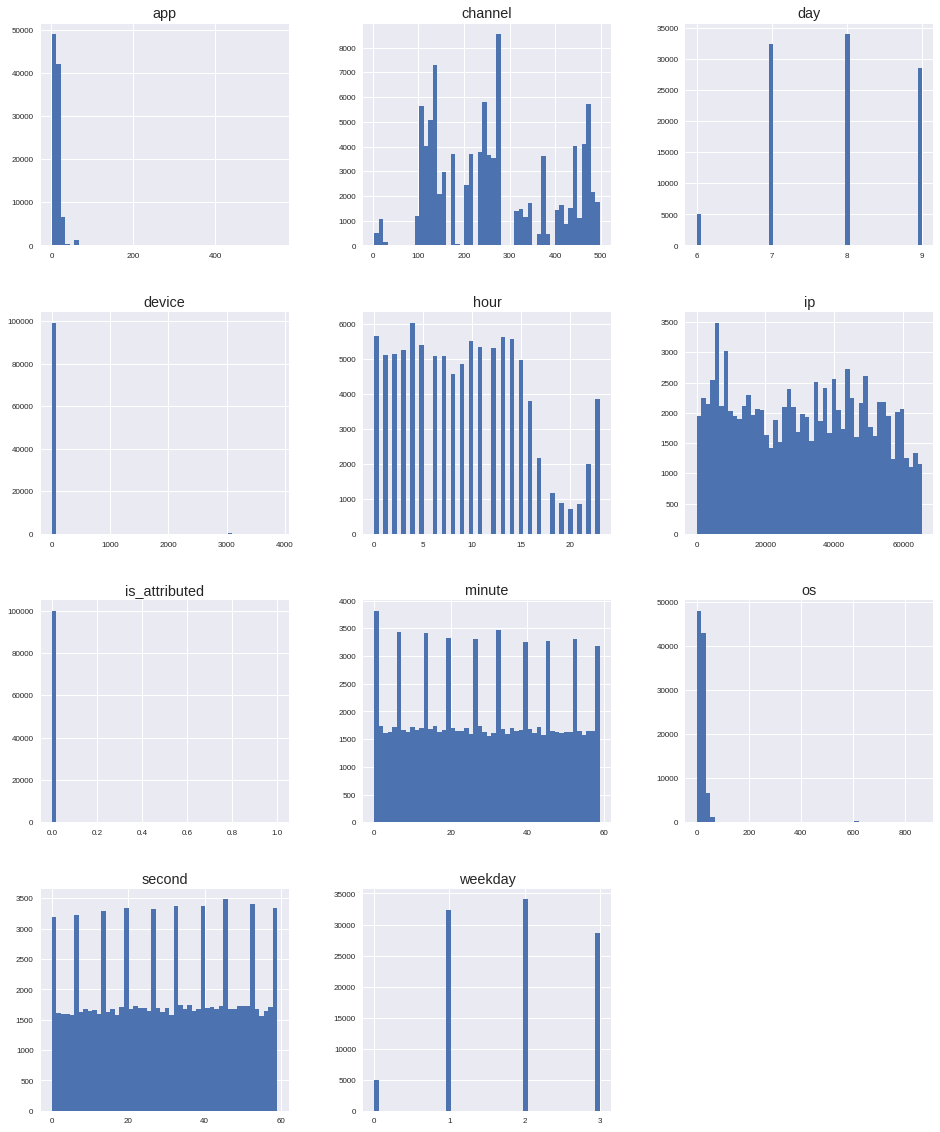

In [17]:
col=['ip',
 'app',
 'device',
 'os',
 'channel',
 'click_time',
 'is_attributed',
 'hour',
 'minute',
 'second',
 'day',
 'weekday'] 

train[col].hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8)


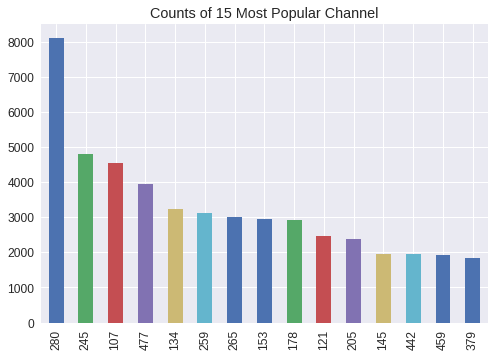

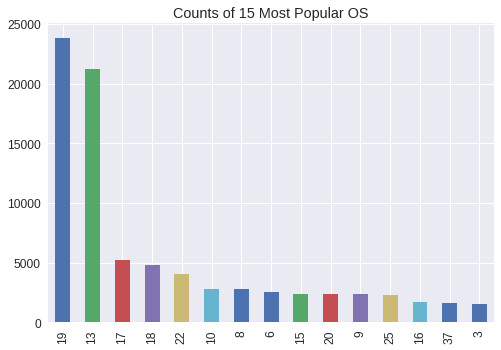

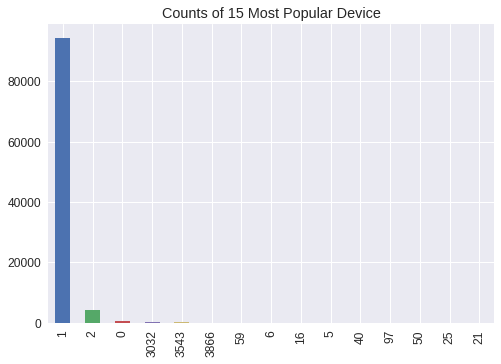

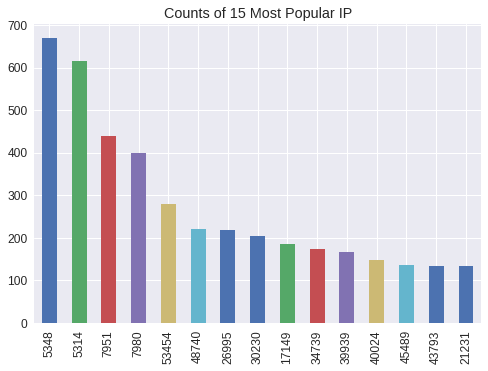

In [87]:
train['channel'].value_counts()[:15].plot('bar')
plt.title('Counts of 15 Most Popular Channel')
plt.show()

train['os'].value_counts()[:15].plot('bar')
plt.title('Counts of 15 Most Popular OS')
plt.show()

train['device'].value_counts()[:15].plot('bar')
plt.title('Counts of 15 Most Popular Device')
plt.show()

train['ip'].value_counts()[:15].plot('bar')
plt.title('Counts of 15 Most Popular IP')
plt.show()

In [0]:
def plotStrip(x, y, hue, figsize = (14, 9)):
    
    fig = plt.figure(figsize = figsize)
    colours = plt.cm.tab10(np.linspace(0, 1, 9))
    with sns.axes_style('ticks'):
        ax = sns.stripplot(x, y, \
             hue = hue, jitter = 0.4, marker = '.', \
             size = 4, palette = colours)
        ax.set_xlabel('')
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(2)

        handles, labels = ax.get_legend_handles_labels()
        plt.legend(handles, ['col1', 'col2'], bbox_to_anchor=(1, 1), \
               loc=2, borderaxespad=0, fontsize = 16);
    return ax

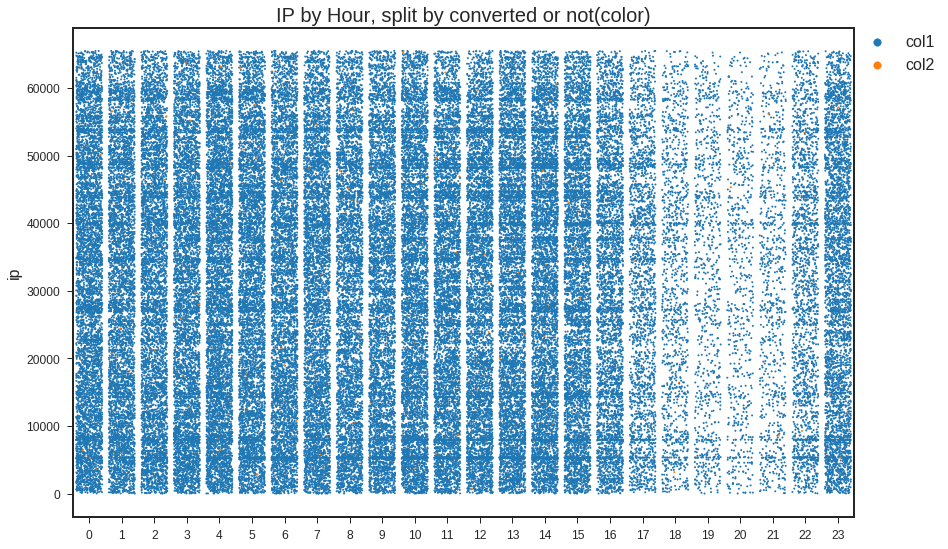

In [76]:
ax = plotStrip(train.hour, train.ip, train.is_attributed)
ax.set_ylabel('ip', size = 16)
ax.set_title('IP by Hour, split by converted or not(color)', size = 20);

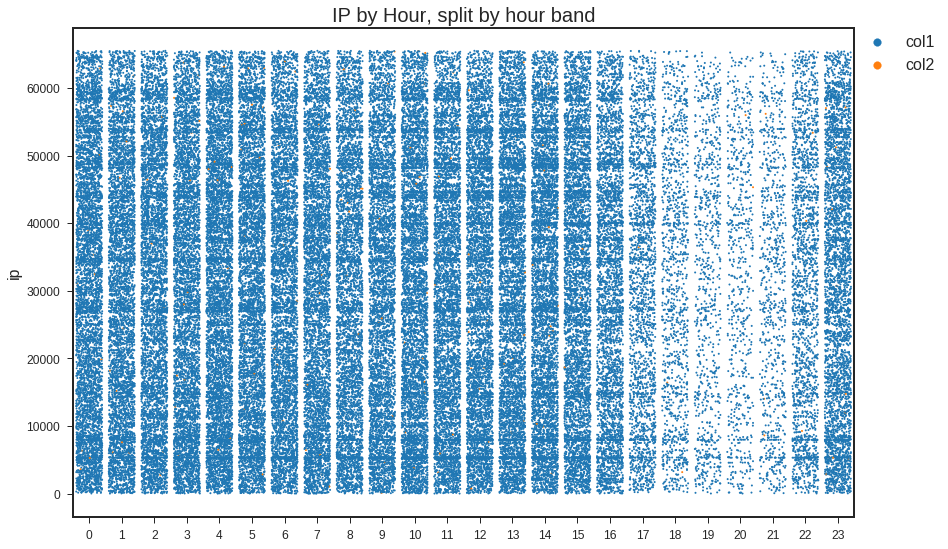

In [73]:
ax = plotStrip(train.hour, train.ip, train.is_attributed)
ax.set_ylabel('ip', size = 16)
ax.set_title('IP by Hour, split by hour band', size = 20);

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


Text(0.5,1,'Not Downloaded click per hour')

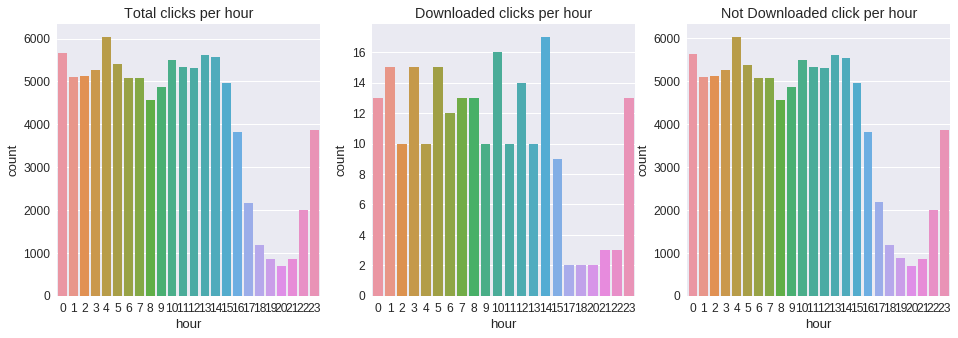

In [28]:
fig, ax = plt.subplots(1,3, figsize = (16,5))

sns.countplot(x='hour', data=train, ax=ax[0])
sns.countplot(x='hour', data=train[train['is_attributed'] == 1], ax = ax[1])
sns.countplot(x='hour', data=train[train['is_attributed'] == 0], ax = ax[2])

ax[0].set_title('Total clicks per hour')
ax[1].set_title('Downloaded clicks per hour')
ax[2].set_title('Not Downloaded click per hour')

Mostly, the clicks less made between 17 to 22. 

Text(0,0.5,'Number of Clicks')

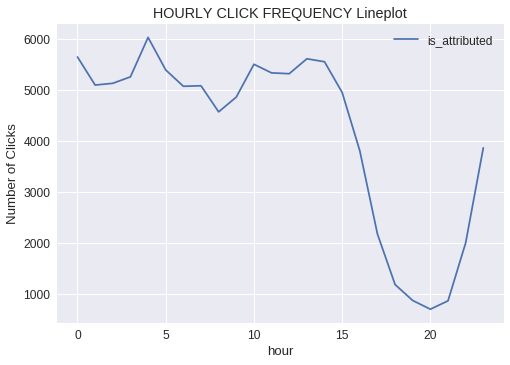

In [21]:
train[['hour','is_attributed']].groupby(['hour'], as_index=True).count().plot()
plt.title('HOURLY CLICK FREQUENCY Lineplot')
plt.ylabel('Number of Clicks')

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


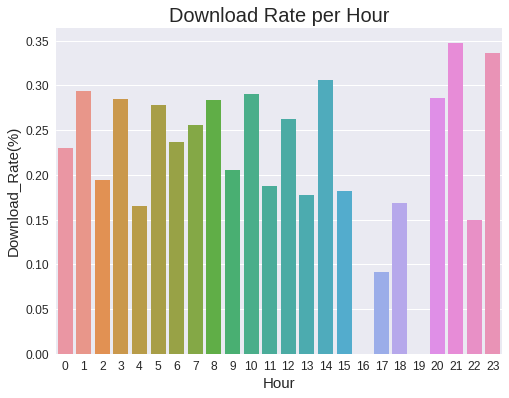

In [22]:
cperhour = train.groupby('hour', as_index = False).count()
cperhour = cperhour[['hour', 'app', 'attributed_time']]
cperhour = cperhour.rename(columns = {'app': 'click_count', 'attributed_time': 'download_count'})
cperhour['download_rate'] = cperhour['download_count'] / cperhour['click_count'] * 100

fig, ax = plt.subplots(figsize=(8, 6))
sns.barplot(x='hour', y='download_rate', data=cperhour)
plt.ylabel('Download_Rate(%)', fontsize=15)
plt.xlabel('Hour', fontsize=15)
ax.set_title('Download Rate per Hour', fontsize = 20)

Text(0,0.5,'Ratio')

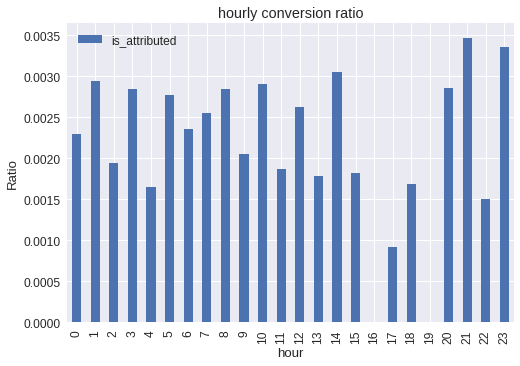

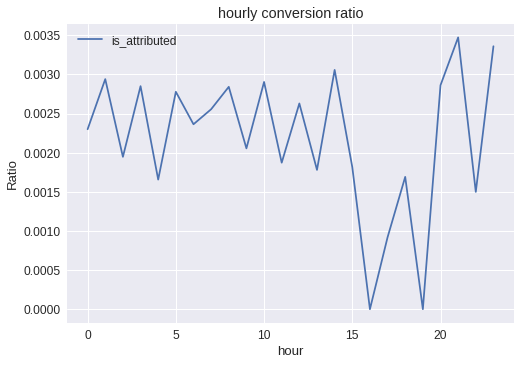

In [50]:
train[['hour','is_attributed']].groupby(['hour'], as_index=True).mean().plot(kind='bar')
plt.title('hourly conversion ratio')
plt.ylabel('Ratio')

train[['hour','is_attributed']].groupby(['hour'], as_index=True).mean().plot()
plt.title('hourly conversion ratio')
plt.ylabel('Ratio')

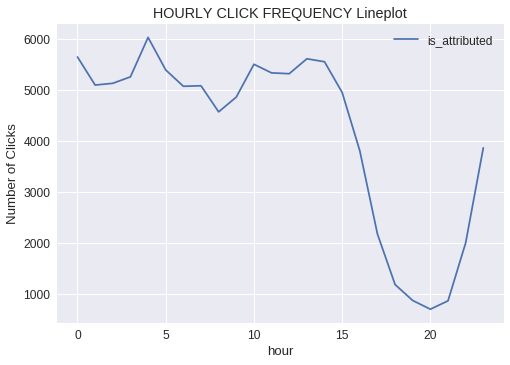

In [24]:
train[['hour','is_attributed']].groupby(['hour'], as_index=True).count().plot()
plt.title('HOURLY CLICK FREQUENCY Lineplot');
plt.ylabel('Number of Clicks');

Text(0.5,1,'Correlationship between each features')

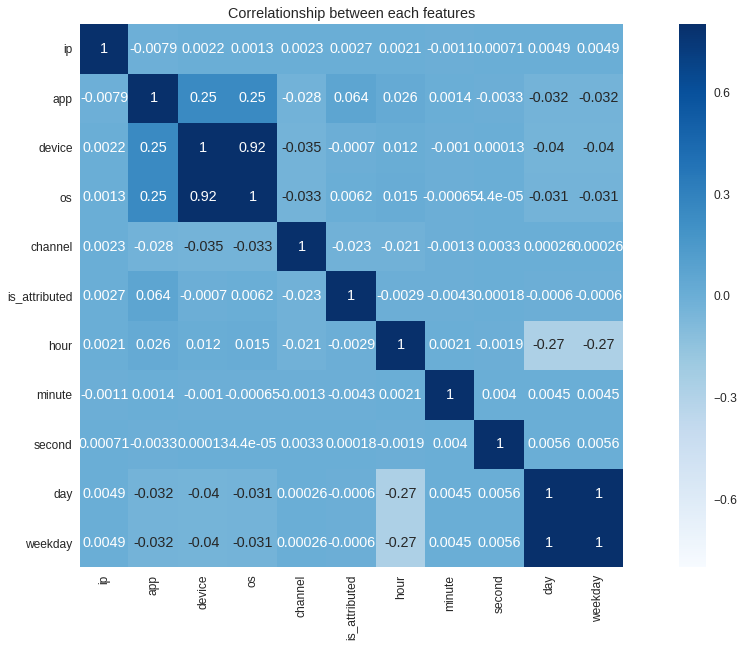

In [25]:
cor = train.corr()
fig, ax = plt.subplots(figsize=(20,10))

sns.heatmap(cor, cmap='Blues', vmax = .8, square = True, ax= ax, annot=True)
ax.set_title('Correlationship between each features')



*   os and device has most correlationship.
*   is_attributed has most correlationship with app.
*   day, weekday, app, device, os have less correlationship.



count    100000.000000
mean      30943.754230
std       18651.939203
min           8.000000
25%       14290.750000
50%       31117.000000
75%       46868.250000
max       65526.000000
Name: ip, dtype: float64


Text(0,0.5,'Percent')

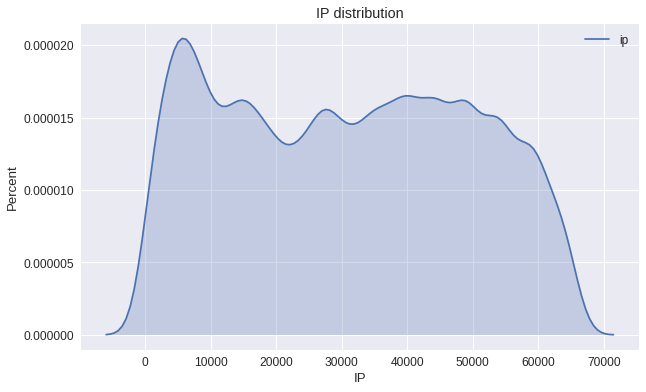

In [26]:
# Check clicks per same ip

print(train['ip'].describe())

fig = plt.subplots(figsize=(10,6))

sns.kdeplot(train['ip'], shade = True)
plt.title ('IP distribution')
plt.xlabel('IP')
plt.ylabel('Percent')

In [29]:
temp = train['ip'].value_counts().reset_index(name='counts')
temp.columns = ['ip', 'counts']
temp[:10]

,ip,counts
0,5348,669
1,5314,616
2,7951,439
3,7980,400
4,53454,280
5,48740,220
6,26995,218
7,30230,205
8,17149,186
9,34739,173


In [31]:
train[train['is_attributed']==1].ip.describe()

count      227.000000
mean     31982.008811
std      19235.252993
min        119.000000
25%      15159.000000
50%      31277.000000
75%      48333.000000
max      65493.000000
Name: ip, dtype: float64

In [0]:
#convert 'is_attributed' back to numeric for proportion calculations
train['is_attributed']=train['is_attributed'].astype(int)

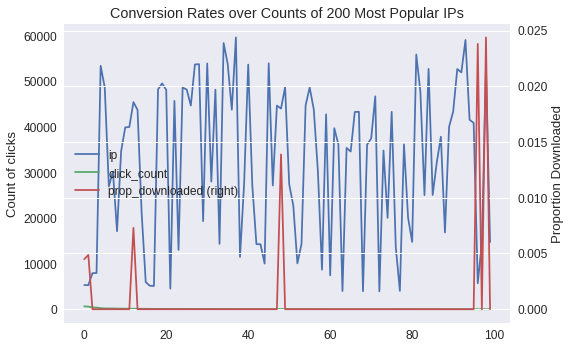

Counversion Rates over Counts of Most Popular IPs
       ip  click_count  prop_downloaded
0    5348          669         0.004484
1    5314          616         0.004870
2    7951          439         0.000000
3    7980          400         0.000000
4   53454          280         0.000000
5   48740          220         0.000000
6   26995          218         0.000000
7   30230          205         0.000000
8   17149          186         0.000000
9   34739          173         0.000000
10  39939          167         0.000000
11  40024          149         0.000000
12  45489          137         0.007299
13  43793          135         0.000000
14  21231          134         0.000000
15   5980          129         0.000000
16   5178          118         0.000000
17   5147          117         0.000000
18  48282          116         0.000000
19  49602          116         0.000000


In [34]:
proportion = train[['ip', 'is_attributed']].groupby('ip', as_index=False).mean().sort_values('is_attributed', ascending=False)
counts = train[['ip', 'is_attributed']].groupby('ip', as_index=False).count().sort_values('is_attributed', ascending=False)
merge = counts.merge(proportion, on='ip', how='left')
merge.columns = ['ip', 'click_count', 'prop_downloaded']

ax = merge[:100].plot(secondary_y='prop_downloaded')
plt.title('Conversion Rates over Counts of 200 Most Popular IPs')
ax.set(ylabel='Count of clicks')
plt.ylabel('Proportion Downloaded')
plt.show()

print('Counversion Rates over Counts of Most Popular IPs')
print(merge[:20])

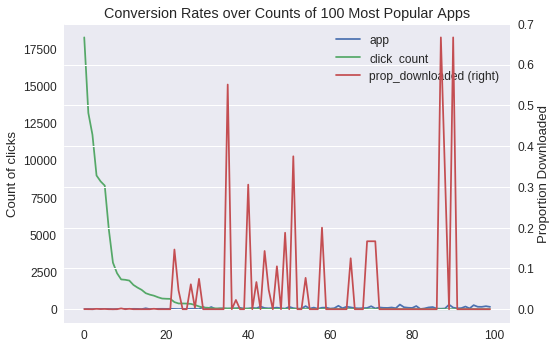

Counversion Rates over Counts of Most Popular Apps
    app  click_count  prop_downloaded
0     3        18279         0.000219
1    12        13198         0.000076
2     2        11737         0.000000
3     9         8992         0.000890
4    15         8595         0.000233
5    18         8315         0.000601
6    14         5359         0.000000
7     1         3135         0.000000
8    13         2422         0.000000
9     8         2004         0.001996
10   21         1979         0.000000
11   11         1927         0.001038
12   26         1633         0.000000
13   23         1454         0.000000
14    6         1303         0.000000
15   64         1079         0.000000
16    7          981         0.000000
17   20          911         0.001098
18   25          804         0.000000
19   28          720         0.000000


In [35]:
proportion = train[['app', 'is_attributed']].groupby('app', as_index=False).mean().sort_values('is_attributed', ascending=False)
counts = train[['app', 'is_attributed']].groupby('app', as_index=False).count().sort_values('is_attributed', ascending=False)
merge = counts.merge(proportion, on='app', how='left')
merge.columns = ['app', 'click_count', 'prop_downloaded']

ax = merge[:100].plot(secondary_y='prop_downloaded')
plt.title('Conversion Rates over Counts of 100 Most Popular Apps')
ax.set(ylabel='Count of clicks')
plt.ylabel('Proportion Downloaded')
plt.show()

print('Counversion Rates over Counts of Most Popular Apps')
print(merge[:20])

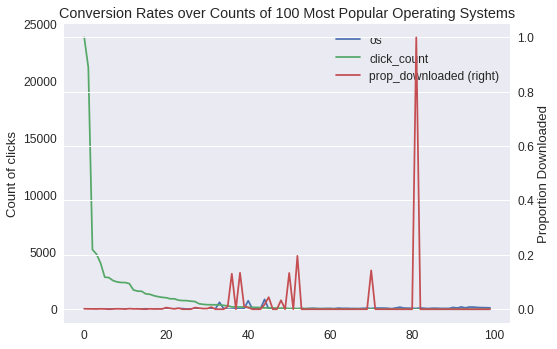

Counversion Rates over Counts of Most Popular Operating Systems
    os  click_count  prop_downloaded
0   19        23870         0.001718
1   13        21223         0.001178
2   17         5232         0.001147
3   18         4830         0.000828
4   22         4039         0.001486
5   10         2816         0.001065
6    8         2775         0.000000
7    6         2520         0.000794
8   15         2396         0.001669
9   20         2347         0.001278
10   9         2341         0.000427
11  25         2248         0.002224
12  16         1691         0.001183
13  37         1589         0.001259
14   3         1576         0.000635
15  41         1348         0.000000
16  14         1312         0.001524
17   1         1185         0.000844
18  12         1103         0.000907
19  23         1042         0.000960


In [42]:
proportion = train[['os', 'is_attributed']].groupby('os', as_index=False).mean().sort_values('is_attributed', ascending=False)
counts = train[['os', 'is_attributed']].groupby('os', as_index=False).count().sort_values('is_attributed', ascending=False)
merge = counts.merge(proportion, on='os', how='left')
merge.columns = ['os', 'click_count', 'prop_downloaded']

ax = merge[:100].plot(secondary_y='prop_downloaded')
plt.title('Conversion Rates over Counts of 100 Most Popular Operating Systems')
ax.set(ylabel='Count of clicks')
plt.ylabel('Proportion Downloaded')
plt.show()

print('Counversion Rates over Counts of Most Popular Operating Systems')
print(merge.head(20))

In [41]:
proportion = train[['device', 'is_attributed']].groupby('device', as_index=False).mean().sort_values('is_attributed', ascending=False)
counts = train[['device', 'is_attributed']].groupby('device', as_index=False).count().sort_values('is_attributed', ascending=False)
merge = counts.merge(proportion, on='device', how='left')
merge.columns = ['device', 'click_count', 'prop_downloaded']

print('Count of clicks and proportion of downloads by device:')
print(merge.head(20))

Count of clicks and proportion of downloads by device:
    device  click_count  prop_downloaded
0        1        94338         0.001548
1        2         4345         0.000460
2        0          541         0.096118
3     3032          371         0.000000
4     3543          151         0.000000
5     3866           93         0.000000
6       59           12         0.000000
7        6            8         0.125000
8       40            7         0.142857
9       16            7         0.428571
10       5            7         0.000000
11      97            5         0.600000
12      50            4         0.250000
13      33            3         0.333333
14      60            3         0.333333
15       4            3         0.333333
16      25            3         0.000000
17      21            3         0.666667
18      30            2         0.500000
19      67            2         0.000000


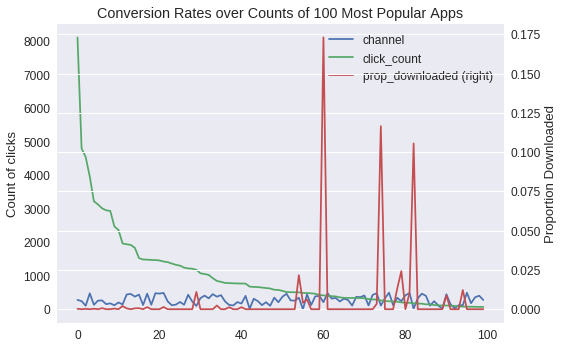

Counversion Rates over Counts of Most Popular Channels
    channel  click_count  prop_downloaded
0       280         8114         0.000246
1       245         4802         0.000000
2       107         4543         0.000220
3       477         3960         0.000000
4       134         3224         0.000310
5       259         3130         0.000000
6       265         3013         0.000664
7       153         2954         0.000000
8       178         2936         0.000000
9       121         2472         0.000405
10      205         2369         0.000000
11      145         1964         0.002037
12      442         1941         0.000515
13      459         1921         0.000000
14      379         1833         0.000546
15      439         1528         0.000654
16      128         1486         0.000000
17      466         1483         0.001349
18      135         1473         0.000000
19      480         1468         0.000000


In [40]:
proportion = train[['channel', 'is_attributed']].groupby('channel', as_index=False).mean().sort_values('is_attributed', ascending=False)
counts = train[['channel', 'is_attributed']].groupby('channel', as_index=False).count().sort_values('is_attributed', ascending=False)
merge = counts.merge(proportion, on='channel', how='left')
merge.columns = ['channel', 'click_count', 'prop_downloaded']

ax = merge[:100].plot(secondary_y='prop_downloaded')
plt.title('Conversion Rates over Counts of 100 Most Popular Apps')
ax.set(ylabel='Count of clicks')
plt.ylabel('Proportion Downloaded')
plt.show()

print('Counversion Rates over Counts of Most Popular Channels')
print(merge.head(20))